# Planes in Satellite Imagery Classification

### Importing the dependencies

In [87]:
import torch
from torch import nn
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.0.1
torchvision version: 0.15.2


## Step 1. Importing the data

Print the list of image data directories:

In [88]:
print(os.listdir('data'))

['planesnet', 'planesnet.json', 'scenes']


### Explaining the data

We store in a "data" variable the JSON format of our images, which contain the data under the RGB format, the labels, locations and scene_ids.

* `data`: The pixel value data for each 20x20 RGB image is stored as a list of 1200 integers within the data list. The first 400 entries contain the red channel values, the next 400 the green, and the final 400 the blue. The image is stored in row-major order so that the first 20 entries of the array are the red channel values of the first row of the image.

* `label`: Valued 1 or 0, representing the "plane" class and "no-plane" class, respectively.

* `locations`: The longitude and latitude coordinates of the image center point.

* `scene_ids`: the unique identifier of the PlanetScope visual scene the image was extracted from.

In [89]:
data = pd.read_json('data\planesnet.json')
data

,data,labels,locations,scene_ids
0,"[206, 195, 187, 183, 177, 175, 174, 193, 198, ...",1,"[-118.40497658522878, 33.940618514147936]",20170620_175442_0e30
1,"[215, 209, 200, 196, 192, 197, 205, 168, 155, ...",1,"[-122.392469714, 37.6176425378]",20161212_180859_0e30
2,"[204, 214, 220, 219, 213, 205, 198, 193, 199, ...",1,"[-122.397578597, 37.6209247852]",20170524_181349_0e2f
3,"[179, 174, 179, 178, 173, 170, 168, 168, 168, ...",1,"[-122.214849831, 37.7203378331]",20161110_180707_0e1f
4,"[222, 222, 218, 214, 208, 205, 207, 206, 206, ...",1,"[-117.862173435, 33.6796854072]",20160813_184932_0c64
...,...,...,...,...
31995,"[217, 197, 206, 221, 219, 200, 202, 222, 231, ...",0,"[-117.51619965614212, 34.08254781774721]",20170726_174731_0f34
31996,"[184, 198, 218, 222, 220, 216, 216, 215, 210, ...",0,"[-117.2352626288379, 32.79485122236176]",20160726_173906_0e0e
31997,"[121, 121, 119, 117, 119, 112, 118, 117, 126, ...",0,"[-121.4835244137727, 38.53386512064711]",20151030_162249_0c03
31998,"[172, 190, 202, 202, 196, 193, 188, 191, 199, ...",0,"[-118.32580026781089, 33.83093529544055]",20160715_174337_0e0e


## Step 2: Preprocessing the data

Dropping unnecessary data:

In [90]:
data.drop("scene_ids", axis=1, inplace=True)
data.drop("locations", axis=1, inplace=True)
data.head()

,data,labels
0,"[206, 195, 187, 183, 177, 175, 174, 193, 198, ...",1
1,"[215, 209, 200, 196, 192, 197, 205, 168, 155, ...",1
2,"[204, 214, 220, 219, 213, 205, 198, 193, 199, ...",1
3,"[179, 174, 179, 178, 173, 170, 168, 168, 168, ...",1
4,"[222, 222, 218, 214, 208, 205, 207, 206, 206, ...",1


The `data` field contains information for each image. Each image consists of a 20x20 pixel grid, with each pixel having RGB color information. Consequently, an image is divided into three parts: the red component (`R_image`), the green component (`G_image`), and the blue component (`B_image`). The `data` field is structured as a list with each component represented as a sequence of 400 values, where each value ranges from 0 to 255.

We split `data` into 1200 columns, one for each `channel_pixel`, so we will have: `r_0...r_399, g_0...g_399, b_0...b_399`.

In [91]:
pixel_columns_name = np.empty(1200, dtype=object)
channels = ["r", "g", "b"] 
for c in channels:
    for p in range(400):
        pixel_columns_name[400*channels.index(c)+p] = c+"_"+str(p)

image_data = pd.DataFrame(data['data'].values.tolist(), columns=pixel_columns_name)
labels = data.labels

image_data = pd.concat([image_data, labels], axis=1)
image_data.head()

,r_0,r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,...,b_391,b_392,b_393,b_394,b_395,b_396,b_397,b_398,b_399,labels
0,206,195,187,183,177,175,174,193,198,197,...,191,193,197,196,198,231,224,194,164,1
1,215,209,200,196,192,197,205,168,155,160,...,190,185,182,192,201,204,205,207,210,1
2,204,214,220,219,213,205,198,193,199,186,...,171,174,173,174,176,171,167,163,157,1
3,179,174,179,178,173,170,168,168,168,170,...,150,152,164,171,171,171,170,169,163,1
4,222,222,218,214,208,205,207,206,206,207,...,164,164,161,156,163,164,166,158,147,1


### 2.1 Visualizing a random image

`plt.imshow(np.array(image_data.iloc[img_number,0:400].values.tolist()).reshape(20,20), cmap='Reds_r')`:

This line displays the Red channel of the image. It extracts the Red channel values (from index 0 to 399) from the dataset, converts them into a NumPy array, and reshapes them to a 20x20 grid. The cmap='`Reds_r`' argument sets the color map to "Reds_r," which visualizes the Red channel with a red colormap.

The next two sets of `plt.subplot, plt.imshow, and plt.title` functions repeat the process for the Green channel (labeled as "G") and the Blue channel (labeled as "B"), resulting in 3 images in the RGB colormap.

Image number: 20910 with label: 0


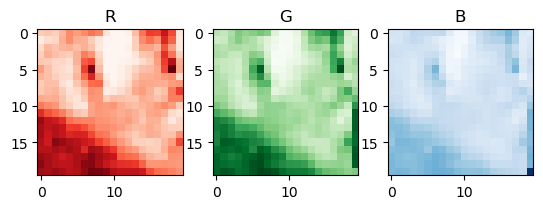

In [92]:
from matplotlib import colors
import random
%matplotlib inline

img_number = random.randrange(0, len(image_data.labels.tolist()))
print("Image number:", img_number, "with label:", image_data.labels[img_number])

plt.subplot(1, 3, 1)
plt.imshow(np.array(image_data.iloc[img_number,0:400].values.tolist()).reshape(20,20), cmap='Reds_r')
plt.title("R")
plt.subplot(1, 3, 2)
plt.imshow(np.array(image_data.iloc[img_number,401:801].values.tolist()).reshape(20,20), cmap='Greens_r')
plt.title("G")
plt.subplot(1, 3, 3)
plt.imshow(np.array(image_data.iloc[img_number,801:1201].values.tolist()).reshape(20,20), cmap='Blues_r')
plt.title("B")
plt.show()

## Step 3. Preparing the data for training

In [93]:
y = image_data.labels
image_data.drop("labels", inplace=True, axis=1)
X = image_data

### 3.1 Creating Train and Test sets

In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(24000, 1200) (8000, 1200) (24000,) (8000,)


### 3.2 Reformatting and reshaping the data to the right format

`Pandas Series -> NumPy array -> Torch Tensor`

To reshape and normalize the images from their initial format to a format suitable for training deep learning models, we need to:

1. Reshape the tensor to have the shape `(batch_size, channels, height, width)`, which is the appropriate format for training Image Classification models in PyTorch.

2. Normalize the pixel values to fall within a specific range, typically between 0 and 1 or -1 and 1, by dividing by 255.

3. Convert to PyTorch Tensor format.

In [95]:
X_train = X_train.to_numpy().reshape(-1, 3,20,20) # 20*20, 3 channels (R-G-B)
X_test = X_test.to_numpy().reshape(-1, 3,20,20) # 20*20, 3 channels (R-G-B)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(24000, 3, 20, 20) (8000, 3, 20, 20) (24000,) (8000,)


In [96]:
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
X_train = X_train / 255.
X_test = X_test / 255.

X_train.shape, X_test.shape
X_train.dtype, X_test.dtype

(torch.float32, torch.float32)

In [97]:
y_train.dtype, y_test.dtype

(dtype('int64'), dtype('int64'))

In [98]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

y_train.dtype, y_test.dtype

(dtype('int64'), dtype('int64'))

In [99]:
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

y_train.shape, y_test.shape

(torch.Size([24000]), torch.Size([8000]))

## Step 4. Prepare DataLoaders for training and testing

Right now, our data is in the form of PyTorch tensor Datasets.

DataLoader turns our dataset into a Python iterable.

More specifically, we want to turn our data into batches (or mini-batches).

In [100]:
from torch.utils.data import TensorDataset

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

In [101]:
from torch.utils.data import DataLoader

# Setup batch size
BATCH_SIZE = 32



# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1ab711f9360>,
 <torch.utils.data.dataloader.DataLoader at 0x1ab711f88b0>)

In [102]:
# Let's check out what we created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001AB711F9360>, <torch.utils.data.dataloader.DataLoader object at 0x000001AB711F88B0>)
Length of train_dataloader: 750 batches of 32
Length of test_dataloader: 250 batches of 32


## Step 5. Building our CNN model 

In [103]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.is_available(), device

(True, 'cuda')

In [104]:
class PlanesOrNotPlanes(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 5 * 5, 128)  # input of this is the half of the output after the last convolutional layer
        self.fc2 = nn.Linear(128, 2)  # 2 output units for binary classification

    def forward(self, x):
        # print(x.shape)
        x = torch.relu(self.conv1(x))
        # print(x.shape)
        x = torch.max_pool2d(x, 2)
        # print(x.shape)
        x = torch.relu(self.conv2(x))
        # print(x.shape)
        x = torch.max_pool2d(x, 2)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = torch.relu(self.fc1(x))
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)
        return x

In [105]:
torch.manual_seed(42)
model = PlanesOrNotPlanes().to(device)
model

PlanesOrNotPlanes(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

## Step 6. Training and testing the model on our data

### 6.1 Setup loss and optimizer (learning rate scheduler optionally)

In [106]:
from helper_functions import accuracy_fn

criterion = nn.CrossEntropyLoss()  # Cross-Entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [107]:
from tqdm import tqdm 

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 10

# Lists to store training and testing losses and accuracy metrics
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss, train_acc = 0, 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        # Moving data to target device
        X = X.to(device)
        y = y.to(device)
        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate the loss per batch
        loss = criterion(y_pred, y)
        train_loss += loss # accumulatively add the loss per batch
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # go from logits -> prediction labels
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    
    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
                # Sending data to target device
            X = X.to(device)
            y = y.to(device)
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate the loss acumulatively
            test_loss += criterion(test_pred, y) # accumulatively add up the loss per epoch
            
            # 3. Calculate accuracy (preds need to be the same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
            
# Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
    
    # Append the losses and accuracies to the respective lists
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/24000 samples


Looked at 12800/24000 samples
Train loss: 0.32980 | Train accuracy: 84.75%


 10%|█         | 1/10 [00:06<00:59,  6.64s/it]


Train loss: 0.32980 | Test loss: 0.18267, Test acc: 93.20%

Epoch: 1
-------
Looked at 0/24000 samples
Looked at 12800/24000 samples
Train loss: 0.16645 | Train accuracy: 93.45%


 20%|██        | 2/10 [00:12<00:50,  6.28s/it]


Train loss: 0.16645 | Test loss: 0.13644, Test acc: 94.66%

Epoch: 2
-------
Looked at 0/24000 samples
Looked at 12800/24000 samples
Train loss: 0.13281 | Train accuracy: 94.92%


 30%|███       | 3/10 [00:18<00:41,  6.00s/it]


Train loss: 0.13281 | Test loss: 0.12973, Test acc: 95.12%

Epoch: 3
-------
Looked at 0/24000 samples
Looked at 12800/24000 samples
Train loss: 0.10955 | Train accuracy: 95.78%


 40%|████      | 4/10 [00:23<00:34,  5.82s/it]


Train loss: 0.10955 | Test loss: 0.15901, Test acc: 93.08%

Epoch: 4
-------
Looked at 0/24000 samples
Looked at 12800/24000 samples
Train loss: 0.09010 | Train accuracy: 96.54%


 50%|█████     | 5/10 [00:29<00:28,  5.66s/it]


Train loss: 0.09010 | Test loss: 0.08983, Test acc: 96.42%

Epoch: 5
-------
Looked at 0/24000 samples
Looked at 12800/24000 samples
Train loss: 0.08359 | Train accuracy: 96.81%


 60%|██████    | 6/10 [00:34<00:22,  5.68s/it]


Train loss: 0.08359 | Test loss: 0.08236, Test acc: 97.08%

Epoch: 6
-------
Looked at 0/24000 samples
Looked at 12800/24000 samples
Train loss: 0.07381 | Train accuracy: 97.14%


 70%|███████   | 7/10 [00:41<00:17,  5.98s/it]


Train loss: 0.07381 | Test loss: 0.10914, Test acc: 95.69%

Epoch: 7
-------
Looked at 0/24000 samples
Looked at 12800/24000 samples
Train loss: 0.07259 | Train accuracy: 97.29%


 80%|████████  | 8/10 [00:47<00:11,  5.96s/it]


Train loss: 0.07259 | Test loss: 0.07552, Test acc: 97.28%

Epoch: 8
-------
Looked at 0/24000 samples
Looked at 12800/24000 samples
Train loss: 0.06259 | Train accuracy: 97.64%


 90%|█████████ | 9/10 [00:52<00:05,  5.80s/it]


Train loss: 0.06259 | Test loss: 0.07018, Test acc: 97.38%

Epoch: 9
-------
Looked at 0/24000 samples
Looked at 12800/24000 samples
Train loss: 0.05948 | Train accuracy: 97.73%


100%|██████████| 10/10 [00:58<00:00,  5.86s/it]


Train loss: 0.05948 | Test loss: 0.07615, Test acc: 96.94%



## Step 7: Plot Train and Test Loss and Accuracy

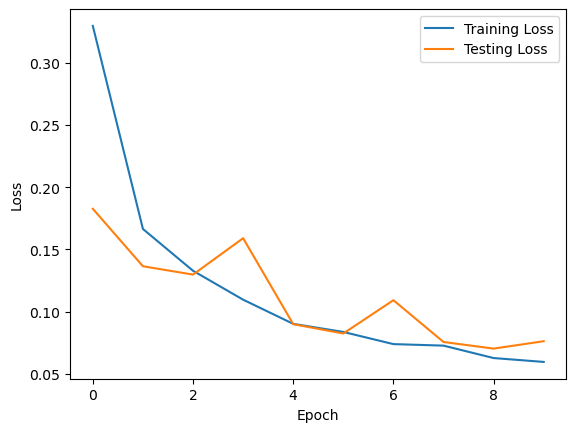

In [108]:
# Plot the losses
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

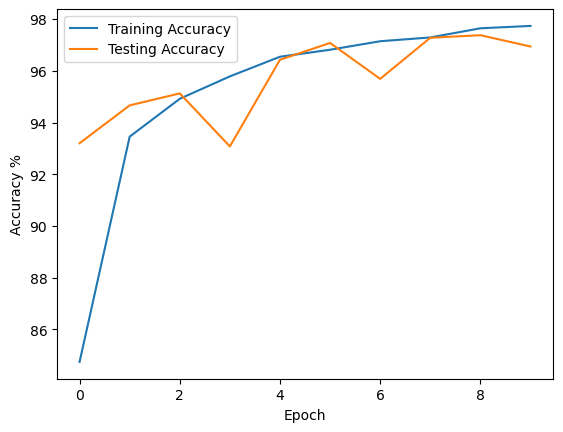

In [109]:
# Plot the accuracy
plt.plot(range(epochs), train_accuracy, label='Training Accuracy')
plt.plot(range(epochs), test_accuracy, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend()
plt.show()

## Step 8. Making predictions on random images

The first reshape that you see on our "img" is because for plotting we need the RGB channels to be in the last dimension.

The second reshape on our "img_tensor" is because for inference we need RGB channels to be in the first dimension.

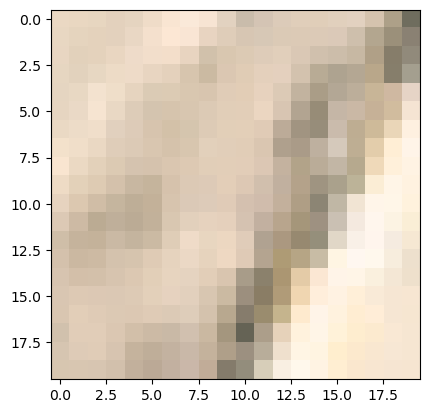

Actual Class: 0
Predicted Class: tensor([[ 6.3038, -4.0919]], device='cuda:0')
Error: tensor([[6.3038, 4.0919]], device='cuda:0')


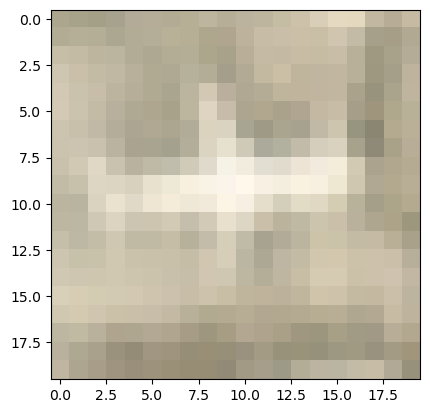

Actual Class: 1
Predicted Class: tensor([[ 6.7013, -5.2351]], device='cuda:0')
Error: tensor([[5.7013, 6.2351]], device='cuda:0')


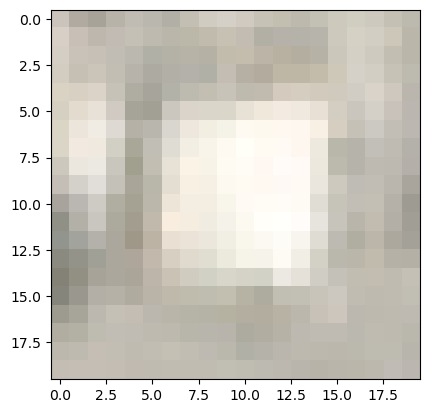

Actual Class: 0
Predicted Class: tensor([[ 5.5570, -4.2531]], device='cuda:0')
Error: tensor([[5.5570, 4.2531]], device='cuda:0')


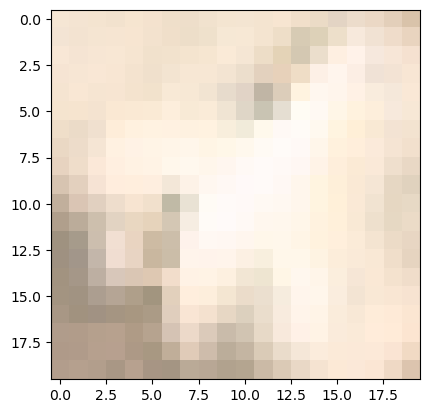

Actual Class: 1
Predicted Class: tensor([[ 8.0579, -6.3461]], device='cuda:0')
Error: tensor([[7.0579, 7.3461]], device='cuda:0')


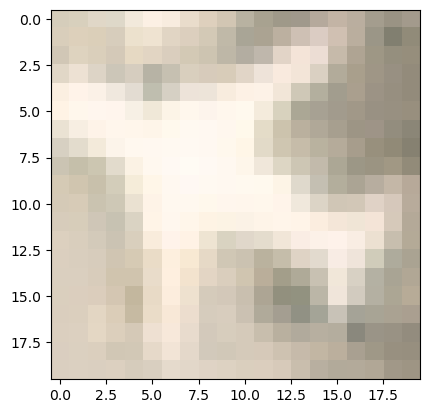

Actual Class: 1
Predicted Class: tensor([[ 5.8224, -3.9856]], device='cuda:0')
Error: tensor([[4.8224, 4.9856]], device='cuda:0')


In [114]:
# Set your model to evaluation mode
model.eval()

for i in range(5):
    # Choose a random image and its label
    rand_int = random.randrange(0, len(data['data']))
    img = np.array(data['data'][rand_int]) / 255.
    img = img.reshape((3, 400)).T.reshape(1, 20, 20, 3) 
    label = data['labels'][rand_int]

    # Convert the image to a PyTorch tensor
    img_tensor = torch.tensor(img, dtype=torch.float32)
    
    # Display the image
    plt.imshow(img[0])
    plt.show()

    # Predict the image class
    with torch.no_grad():
        img_tensor = img_tensor.reshape(img_tensor.shape[0], 3,20,20)
        img_tensor = img_tensor.to(device)
        prediction = model(img_tensor)

    # Output actual and predicted class - 0 = 'no-plane', 1 = 'plane'
    print('Actual Class: ' + str(label))
    print('Predicted Class: ' + str(prediction))
    print('Error: ' + str(abs(label - prediction)))

## Step 9. Saving our model

In [111]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "planes_not_planes_classifier.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\planes_not_planes_classifier.pth
